In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.ma.core import indices
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [2]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: /root/.kaggle/kaggle.json: No such file or directory


In [3]:
import pathlib
from torchvision.datasets import Food101
from torchvision.transforms import v2

data_path = "/Users/denizkonuk/Pytorch/pytorch/data/food-101/"
data_path = pathlib.Path(data_path)



train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

food101_train = Food101(root=data_path, split="train", download=False, transform=train_transforms)
food101_test = Food101(root=data_path, split="test", download=False, transform=test_transforms)

#print(f"Number of training samples: {len(food101_train)}")
#print(f"Number of test samples: {len(food101_test)}")

In [40]:
from torch.utils.data import Subset
# Select random classes for training to decrease the dataset size
import random

all_classes = food101_train.classes
num_classes_to_use = 10 # Change this value to the number of classes you want to use
random_classes = random.sample(range(len(all_classes)), num_classes_to_use)

def filter_dataset(dataset, class_indices_to_keep):
    original_len = len(dataset)
    class_names_to_keep = [dataset.classes[i] for i in class_indices_to_keep]

    indices = []
    new_targets = []
    for i in range(len(dataset)):
        if dataset[i][1] in class_indices_to_keep:
            indices.append(i)
            new_targets.append(class_indices_to_keep.index(dataset[i][1]))

    filtered_dataset = Subset(dataset, indices)
    filtered_dataset.targets = new_targets
    filtered_dataset.classes = class_names_to_keep
    filtered_dataset.class_to_idx = {cls: idx for idx, cls in enumerate(class_names_to_keep)}

    print(f"Original dataset size: {original_len}")
    print(f"Filtered dataset size: {len(filtered_dataset)}")
    print(f"Number of classes kept: {len(class_indices_to_keep)}")

    return filtered_dataset

# Create and filter datasets
food101_train = Food101(root=data_path, split="train", download=False, transform=train_transforms)
food101_test = Food101(root=data_path, split="test", download=False, transform=test_transforms)

food101_train_filtered = filter_dataset(food101_train, random_classes)
food101_test_filtered = filter_dataset(food101_test, random_classes)



Original dataset size: 75750
Filtered dataset size: 7500
Number of classes kept: 10
Original dataset size: 25250
Filtered dataset size: 2500
Number of classes kept: 10


In [41]:

print(f"Number of training samples: {len(food101_train_filtered)}")
print(f"Number of test samples: {len(food101_test_filtered)}")

Number of training samples: 7500
Number of test samples: 2500


In [42]:
print("Clases in the filtered dataset:")
for class_name in food101_train_filtered.classes:
    print(class_name)

Clases in the filtered dataset:
samosa
huevos_rancheros
cannoli
cheesecake
grilled_cheese_sandwich
waffles
breakfast_burrito
paella
takoyaki
beignets


In [43]:
print("Random classes selected:")
print(random_classes)
print(f"Number of random classes: {len(random_classes)}")

Random classes selected:
[85, 56, 12, 17, 49, 100, 9, 71, 97, 6]
Number of random classes: 10


In [44]:
import random
from PIL import Image
sample_idx = 2507
img, label = food101_train[sample_idx]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Class name: {food101_train.classes[label]}")

Image shape: torch.Size([3, 224, 224])
Label: 86
Class name: sashimi


In [45]:
print("Class names:")
print(food101_train_filtered.classes)  # Print first 10 class names
print(food101_test_filtered.classes)

Class names:
['samosa', 'huevos_rancheros', 'cannoli', 'cheesecake', 'grilled_cheese_sandwich', 'waffles', 'breakfast_burrito', 'paella', 'takoyaki', 'beignets']
['samosa', 'huevos_rancheros', 'cannoli', 'cheesecake', 'grilled_cheese_sandwich', 'waffles', 'breakfast_burrito', 'paella', 'takoyaki', 'beignets']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.3585434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7870152..1.3755461].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].


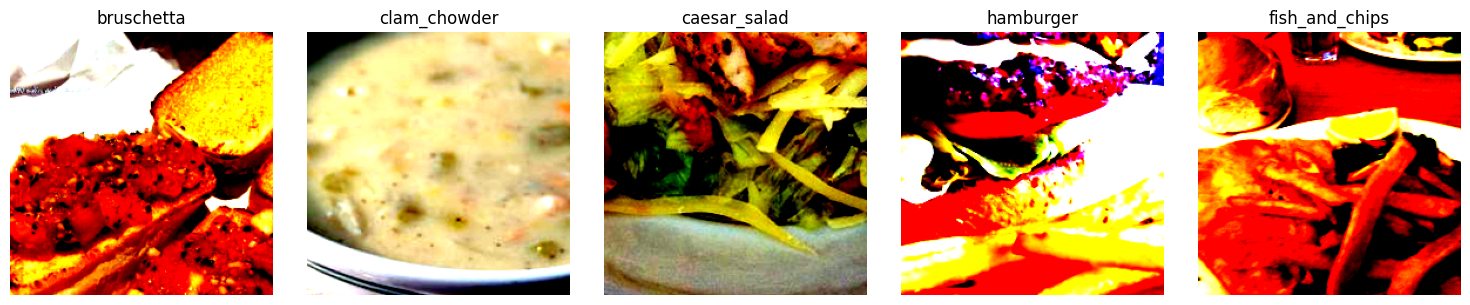

In [46]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        idx = torch.randint(0, len(dataset), (1,)).item()
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        axes[i].set_title(dataset.classes[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_images(food101_train)

In [47]:
# Create DataLoaders

train_loader = DataLoader(dataset=food101_train_filtered, batch_size=128, shuffle=True, num_workers=12)
test_loader = DataLoader(dataset=food101_test_filtered, batch_size=128, shuffle=False, num_workers=12)

In [55]:
# Let's create a model
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units*2,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2,
                    out_channels=hidden_units*2,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2,
                    out_channels=hidden_units*2,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(food101_train_filtered.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=10, bias=True)
  )
)

In [56]:
# Use torchinfo to get an idea of the model
from torchinfo import summary
summary(model_0, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-5                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 64, 112, 112]         36,928
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-10                      [1, 64, 112, 112]         36,

In [57]:
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=len(food101_train_filtered.classes)).to(device)

In [58]:
# Create a train step

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        #Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [59]:
# Let's create the test step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0


    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(test_pred, y)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [62]:
# Combine train and test functions

from tqdm import tqdm

# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 50):

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    # Loop through training and test steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        #Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # Return the filled results at the end of the epochs
    return results


In [63]:
#Time to train the model

torch.manual_seed(42)
torch.mps.manual_seed(42)

NUM_EPOCHS = 50

#Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(food101_train_filtered.classes)).to(device)

#Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

#Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:39<31:53, 39.06s/it]

Epoch: 1 | train_loss: 0.1460 | train_acc: 0.1122 | test_loss: 0.1150 | test_acc: 0.1340


  4%|▍         | 2/50 [01:18<31:22, 39.22s/it]

Epoch: 2 | train_loss: 0.1155 | train_acc: 0.1424 | test_loss: 0.1113 | test_acc: 0.1359


  6%|▌         | 3/50 [01:57<30:48, 39.33s/it]

Epoch: 3 | train_loss: 0.1081 | train_acc: 0.1504 | test_loss: 0.0981 | test_acc: 0.1461


  8%|▊         | 4/50 [02:37<30:11, 39.38s/it]

Epoch: 4 | train_loss: 0.1038 | train_acc: 0.1527 | test_loss: 0.1132 | test_acc: 0.1375


 10%|█         | 5/50 [03:16<29:34, 39.43s/it]

Epoch: 5 | train_loss: 0.0964 | train_acc: 0.1563 | test_loss: 0.0888 | test_acc: 0.1570


 12%|█▏        | 6/50 [03:56<28:56, 39.46s/it]

Epoch: 6 | train_loss: 0.1000 | train_acc: 0.1534 | test_loss: 0.0914 | test_acc: 0.1562


 14%|█▍        | 7/50 [04:35<28:18, 39.51s/it]

Epoch: 7 | train_loss: 0.0910 | train_acc: 0.1595 | test_loss: 0.0851 | test_acc: 0.1543


 16%|█▌        | 8/50 [05:15<27:35, 39.41s/it]

Epoch: 8 | train_loss: 0.0911 | train_acc: 0.1608 | test_loss: 0.0928 | test_acc: 0.1500


 18%|█▊        | 9/50 [05:54<26:58, 39.48s/it]

Epoch: 9 | train_loss: 0.0865 | train_acc: 0.1618 | test_loss: 0.0844 | test_acc: 0.1605


 20%|██        | 10/50 [06:34<26:20, 39.51s/it]

Epoch: 10 | train_loss: 0.0826 | train_acc: 0.1636 | test_loss: 0.0819 | test_acc: 0.1578


 22%|██▏       | 11/50 [07:13<25:41, 39.53s/it]

Epoch: 11 | train_loss: 0.0824 | train_acc: 0.1628 | test_loss: 0.0871 | test_acc: 0.1562


 24%|██▍       | 12/50 [07:53<25:02, 39.53s/it]

Epoch: 12 | train_loss: 0.0854 | train_acc: 0.1621 | test_loss: 0.0869 | test_acc: 0.1594


 26%|██▌       | 13/50 [08:32<24:22, 39.53s/it]

Epoch: 13 | train_loss: 0.0789 | train_acc: 0.1663 | test_loss: 0.0725 | test_acc: 0.1641


 28%|██▊       | 14/50 [09:12<23:43, 39.55s/it]

Epoch: 14 | train_loss: 0.0808 | train_acc: 0.1649 | test_loss: 0.0726 | test_acc: 0.1621


 30%|███       | 15/50 [09:52<23:03, 39.53s/it]

Epoch: 15 | train_loss: 0.0772 | train_acc: 0.1668 | test_loss: 0.0669 | test_acc: 0.1668


 32%|███▏      | 16/50 [11:24<31:21, 55.34s/it]

Epoch: 16 | train_loss: 0.0780 | train_acc: 0.1692 | test_loss: 0.0713 | test_acc: 0.1629


 34%|███▍      | 17/50 [17:54<1:25:50, 156.07s/it]

Epoch: 17 | train_loss: 0.0738 | train_acc: 0.1680 | test_loss: 0.0849 | test_acc: 0.1516


 34%|███▍      | 17/50 [18:18<35:32, 64.61s/it]   


KeyboardInterrupt: 